<a href="https://colab.research.google.com/github/cisprague/bts-2021/blob/main/bts-2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System identification of AUVs with physics-informed learning

Christopher Iliffe Sprague (sprague@kth.se)

Sriharsha Bhat (svbhat@kth.se)

# Outline

- Background
- What's the benefit?
- Data generation
- Model identification
- Simulation
- Discussion and future work

# Background

## AUVs

Consider SAM, a slender AUV with counter-rotating propellers, thrust vectoring, and trim systems. SAM is a small and hydrobatic AUV, capable of agile maneuvers while still being efficient in speed and range. A lot of the non-conservative forces are difficult to model, so here we will try to learn them.

![sim_reality](https://drive.google.com/uc?export=view&id=1vcuj3Cjt08Li1FB6ZndiquqFNPaYOGfT)
*Figure: The SAM AUV in the field, and in simulation.*










## Resources

Here, we just import all the packages that are needed for this tutorial. This might take a moment.

In [2]:
# JAX for autograd and and numerics
! pip install --upgrade pip
! pip install --upgrade "jax[cuda101]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
import jax.numpy as np
from jax import jit, vmap, jacobian, hessian, grad
from jax.experimental.ode import odeint
from jax.random import uniform, choice
from jax.nn import softplus
from jax.lax import stop_gradient

# Haiku for neural networks
! pip install git+https://github.com/deepmind/dm-haiku
import haiku as hk

# Optax for optimisation
! pip install git+https://github.com/deepmind/optax
import optax

# TQDM for training loop feedback
! pip install tqdm
from tqdm.notebook import tqdm

# SKLearn for preprocessing data
from sklearn.preprocessing import StandardScaler

# treating some arguments as static
from functools import partial

# computer algebra
import sympy

# saving and loading models
import pickle

# matplotlib for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# use vector graphics in the notebook
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-76jswek9
  Running command git clone -q https://github.com/deepmind/dm-haiku /tmp/pip-req-build-76jswek9
  Resolved https://github.com/deepmind/dm-haiku to commit 399c6fe6f2bba35aad10d52cee67c3bab6cd261b
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/deepmind/optax to /tmp/pip-req-build-yauk28t4
  Running command git clone -q https://github.com/deepmind/optax /tmp/pip-req-build-yauk28t4
  Resolved https://github.com/deepmind/optax to commit b86a00ce06796263cd73aa9a8aef2bc78eea9c09
Defaulting to user installation because normal site-packages is not wri

In [3]:
# This just print which device we are using (hopefully a GPU).
from jax.lib import xla_bridge
print('We are using the {}'.format(xla_bridge.get_backend().platform))

We are using the gpu


In [4]:
# This is a random seed generator: use `next(key)` to get a seed.
key = hk.PRNGSequence(42)

# Analytical equations

Here we will write the code for things that we *do* know about the system, such as basic mathematical transormations and lower and upper bounds of certain variables.

## State-space
We will gather data from an analytical model of an AUV, so that we can compare the learned/identified model with a ground truth. However, in practice, one can also use other data as input, such as AUV pose data from missions. 

A six degree-of freedom AUV model is used leading to 12 states ($x,y,z,\phi,\theta,\psi,u,v,w,p,q,r $), based on Fossen's notation. 

The kinematics are of the form
    $\dot \eta = J_{euler}(\eta)\nu$ , 
    where $\eta$ represents the vector of positions and orientations in Euler angles, while $\nu$ represents the vector of velocities and angular velocities and $J_{euler}\in\mathbb{R}^{6 \times 6}$ is the kinematic transformation matrix. 

The dynamics are of the form
    $M_{\text{eff}} \dot\nu + C_{\text{eff}}(\nu)\nu + D_(\nu)\nu + g(\eta) = \tau_C$, 
    where M represents the combined mass and inertia matrix (considering rigid body terms, but added mass terms can also be included), C is the combined coriolis-centripetal matrix, D is the damping matrix (considering hydrodynamics), g represents the buoyancy forces (considering hydrostatics) and $\tau_C$ refers to the vector of external control forces (such as from actuators).

The hydrodynamic damping in particular is very difficult to model, since the flow around a slender body can transition to turbulent flow at higher angles of attack and Reynolds numbers.  

![vortex pair](https://drive.google.com/uc?export=view&id=1dFszaOHlbwP1LXMtC3WZVsUHtg0xiopB)
*Figure: Vortex shedding from a slender body at an angle of attack of 37°.*


The AUV under consideration (SAM) has 6 actuators including counter-rotating propellers (to control speed and roll), thrust vectoring(for yaw and pitch), longitudinal center of gravity(for static pitching and gliding) and a variable buoyancy system (to regulate buoyancy) and is underactuated. The effect of these actuators are included in the code below.

![SAM hardware](https://drive.google.com/uc?export=view&id=1c5KqPVnk8RKKVlJN38UJYj5tMknRwPZ4)
*Figure: The actuator subsystems on SAM*


In this tutorial, we are following the Fossen model for AUVs.
Formally, the state of this system $s \in \mathbb{R}^{12}$ is given by
\begin{align}
s = [
  x, y, z, \phi, \theta, \psi, u, v, w, p, q, r
],
\end{align}
where $$\eta = [x, y, z, \phi, \theta, \psi]$$ is the position and orientation in the north-east-down (NED) frame and 
$$\nu = [u, v, w, p, q, r]$$
is the translational and angular velocity in the body frame.

When we train our model, we want to make sure that we are seeing a variety of different states so that our model can generalize well. In system-identification parlance, this is sometimes known as *percistant excitation*.

In [5]:
# dimensions
dim_state = 12
#dim_control = 6 #with rpm1,rpm2,de,dr,vbs,lcg
dim_control = 4 #with rpm1,rpm2,de,dr,vbs,lcg

In [6]:
# state bounds for training
bounds_state_train = np.array([*[20]*3, *[2*np.pi]*3, *[5]*3, *[5]*3])
bounds_state_test = bounds_state_train/4
bounds_state_train = (-bounds_state_train, bounds_state_train)
bounds_state_test = (-bounds_state_test, bounds_state_test)

In [7]:
# control bounds
bounds_control_train = np.full(dim_control, 1.5)
bounds_control_test = bounds_control_train/2
bounds_control_train = (-bounds_control_train, bounds_control_train)
bounds_control_test = (-bounds_control_test, bounds_control_test)

## Testing data

write more stuff


In [8]:
# random states and controls
n = 10
states_test = uniform(
    next(key),
    (10, dim_state),
    minval=bounds_state_test[0],
    maxval=bounds_state_test[1]
)
controls_test = uniform(
    next(key),
    (10, dim_control),
    minval=bounds_control_test[0],
    maxval=bounds_control_test[1]
)

In [9]:
# nominal state and control
state = np.zeros((dim_state,))
control = np.ones((dim_control,))
state, control

(DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 DeviceArray([1., 1., 1., 1.], dtype=float32))

## Transformations

Common transformations, elaborate a little

In [10]:
# skew matrix of vector
@jit
def skew(vec):
  return np.array([
    [0, -vec[2], vec[1]],
    [vec[2], 0, -vec[0]],
    [-vec[1], vec[0], 0]
  ])

In [11]:
# vector from skew matrix
@jit
def unskew(mat):
    return np.array([
        mat[2,1],
        mat[0,2],
        mat[1,0]
    ])

In [12]:
# rotation matrix from body to NED for linear vectors
@jit
def R_b2ned(phi, theta, psi):
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi), np.cos(phi)]
    ])
    Ry = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    Rz = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])
    R = Rz@Ry@Rx
    return R

In [13]:
# rotation matrix from body to NED for angular vectors
@jit
def T_b2ned(phi, theta, psi):
    T = np.array([
        [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)],
    ])
    return T

In [14]:
@jit
def f_analytical_terms(state, control):

  # state and control
  x, y, z, phi, theta, psi, u, v, w, p, q, r = state
  #rpm1, rpm2, de, dr, lcg, vbs = control
  rpm1, rpm2, de, dr = control

  # position (NED) and velocity (body), rsp
  eta = np.array([x, y, z, phi, theta, psi])
  nu = np.array([u, v, w, p, q, r])

  # scaled controls
  rpm1 *= 1000.0
  rpm2 *= 1000.0
  de *= 0.05
  dr *= 0.05
  # vbs *= 1.0
  # lcg *= 1.0

  # mass and inertia matrix
  m = 14.0
  I_o = np.diag(np.array([0.0294, 1.6202, 1.6202]))

  # centre of gravity, buoyancy, and pressure positions, resp.
  #r_g = np.array([0.1 + lcg*0.01, 0.0, 0.0])
  r_g = np.array([0.1, 0.0, 0.0]) #no effect of Longitudinal C.G. trim system
  r_b = np.array([0.1, 0.0, 0.0])
  r_cp = np.array([0.1, 0.0, 0.0])

  # <insert title>
  W = m*9.81
  #B = W + vbs*1.5
  B = W #no effect of Variable buoyancy system

  # hydrodynamic coefficients
  Xuu = 5. #3. #1.0
  Yvv = 20. #10. #100.0
  Zww = 50. #100.0
  Kpp = 0.1 #10.0
  Mqq = 20.#40 #100.0
  Nrr = 20. #150.0

  # control actuators
  K_T = np.array([0.0175, 0.0175])
  Q_T = np.array([0.001, -0.001])#*0.0

  # mass and inertia matrix
  M = np.block([
    [m*np.eye(3,3), -m*skew(r_g)],
    [m*skew(r_g), I_o]
  ])
  assert M.shape == (6,6), M

  # coriolis and centripetal matrix
  nu1 = np.array([u, v, w])
  nu2 = np.array([p, q, r])
  top_right = -m*skew(nu1) - m*skew(nu2)*skew(r_g)
  bottom_left = -m*skew(nu1) + m*skew(r_g)*skew(nu2)
  bottom_right = -skew(I_o.dot(nu2))
  C_RB = np.block([
    [np.zeros((3,3)), top_right],
    [bottom_left, bottom_right]
  ])
  assert C_RB.shape == (6, 6), C_RB

  # damping matrix
  forces = np.diag(np.array([Xuu*np.abs(u), Yvv*np.abs(v), Zww*np.abs(w)]))
  moments = np.diag(np.array([Kpp*np.abs(p), Mqq*np.abs(q), Nrr*np.abs(r)]))
  coupling = np.matmul(skew(r_cp), forces)
  D = np.block([[forces, np.zeros((3, 3))], [-coupling, moments]])
  assert D.shape == (6, 6), D

  # rotational transform between body and NED in Euler
  T_euler = T_b2ned(phi, theta, psi)      
  R_euler = R_b2ned(phi, theta, psi)
  assert R_euler.shape == (3,3), R_euler
  J_eta = np.block([
    [R_euler, np.zeros((3,3))],
    [np.zeros((3,3)), T_euler]
  ])
  assert J_eta.shape == (6,6), J_eta

  # buoyancy in quaternions
  f_g = np.array([0, 0, W])
  f_b = np.array([0, 0, -B])
  row1 = np.linalg.inv(R_euler).dot(f_g + f_b)
  row2 = skew(r_g).dot(np.linalg.inv(R_euler)).dot(f_g) + \
    skew(r_b).dot(np.linalg.inv(R_euler)).dot(f_b)
  geta = np.block([row1, row2])
  assert geta.shape == (6,), geta

  # <insert title>
  F_T = K_T.dot(np.array([rpm1, rpm2]))
  M_T = Q_T.dot(np.array([rpm1, rpm2]))
  tauc = np.array([
    F_T*np.cos(de)*np.cos(dr),
    -F_T*np.sin(dr),
    F_T*np.sin(de)*np.cos(dr),
    M_T*np.cos(de)*np.cos(dr),
    -M_T*np.sin(dr),
    M_T*np.sin(de)*np.cos(dr)
  ])
  assert tauc.shape == (6,), tauc

  # rate of change of position in NED frame
  etadot = np.block([J_eta.dot(nu)])
  assert etadot.shape == (6,)

  # etadot and terms for rate of change of velocity in body frame
  return eta, etadot, M, tauc, C_RB, D, nu, geta

In [15]:
@jit
def f_analytical(state, control):

  # Fossen terms
  eta, etadot, M, tauc, C_RB, D, nu, geta = f_analytical_terms(state, control)

  # acceleration in body
  nudot = np.linalg.pinv(M).dot(tauc - (C_RB + D).dot(nu) - geta)

  # state-space dynamics
  return np.hstack((etadot, nudot))

# Visualization

In [16]:
# integrates a single trajectory with constant control
@partial(jit, static_argnums=(2,3,4))
def trajectory_constant(x, u, f, T, h):
    return odeint(lambda x, t: f(x, u), x, np.arange(0.0, T, h))

# integrates multiple trajectories in parallel with constant control
trajectories_constant = jit(
    vmap(trajectory_constant, in_axes=(0,0, None, None, None)),
    static_argnums=(2,3,4)
)

In [17]:
def plot(trajs_list, markers, labels):

    # setup
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot
    for trajs, marker, label in zip(trajs_list, markers, labels):
        for i, traj in enumerate(trajs):
            label = None if i > 0 else label
            ax.plot(traj[:1,0], traj[:1,1], traj[:1,2], 'ko', label=None)
            ax.plot(traj[:,0], traj[:,1], traj[:,2], marker, label=label)

    # format
    ax.set_xlabel('$x~[m]$')
    ax.set_ylabel('$y~[m]$')
    ax.set_zlabel('$z~[m]$')
    plt.legend()
    plt.show()

Show a spiral trajectory with some arrows. Something that looks cool

In [18]:
# trajs_list = [
#   trajectories_constant(states_test, controls_test, f_analytical, 10, 0.1)
# ]
# plot(trajs_list, ['k-'], ['Analytical'])

In [19]:
# trajs_list = [
#   [trajectory_constant(state, control, f_analytical, 200.0, 0.1)]
# ]
# plot(trajs_list, ['k-'], ['Analytical'])

# Machine learning

Since the damping matrix is so difficult to model, we will attempt to learn it here from data. Fossen says that the damping matrix is a nonlinear function of the rates $D(\nu)$.

## Learning model

In [20]:
def F_nn(state, control):

  # Fossen terms
  eta, etadot, M, tauc, C_RB, D, nu, geta = f_analytical_terms(state, control)

  # estimate damping with NN
  forces = hk.nets.MLP([*[100]*3, 3], b_init=hk.initializers.RandomNormal())(nu[0:3]) # Linear damping depends on linear velocity
  moments = hk.nets.MLP([*[100]*3, 3], b_init=hk.initializers.RandomNormal())(nu[3:6]) # Angular damping depends on angular velocity
  # r_cp = hk.nets.MLP([*[20]*3, 3], b_init=hk.initializers.RandomNormal())(np.hstack((nu))) # Center of pressure depends on velocity
  r_cp = np.array([0.1, 0.0, 0.0])
  forces = np.diag(forces)
  moments = np.diag(moments)
  coupling = np.matmul(skew(r_cp), forces)
  D = np.block([[forces, np.zeros((3, 3))], [-coupling, moments]])
  # D = hk.nets.MLP([*[100]*3, 6**2])(nu).reshape((6,6))

  # Fossen
  nudot = np.linalg.pinv(M).dot(tauc - (C_RB + D).dot(nu) - geta)
  return np.hstack((etadot, nudot))

In [21]:
# we need to initialize the model
f_nn = hk.without_apply_rng(hk.transform(F_nn))
params = f_nn.init(next(key), state, control)

## Loss function

In [22]:
@partial(jit, static_argnums=(2,))
def loss(params, key, n):

    # generate random states
    states = uniform(
        key,
        shape=(n, dim_state),
        minval=bounds_state_train[0],
        maxval=bounds_state_train[1]
    )

    # generate random controls
    controls = uniform(
        key,
        shape=(n, dim_control),
        minval=bounds_control_train[0],
        maxval=bounds_control_train[1]
    )

    # analytical time-derivatives
    dstates = vmap(f_analytical, in_axes=(0,0))(states, controls)

    # predictions
    dstates_nn = vmap(f_nn.apply, in_axes=(None,0,0))(params, states, controls)

    # mean-squared-error loss in acceleration
    loss = dstates[:,6:] - dstates_nn[:,6:]
    loss = np.average(np.square(loss))
    return loss, loss

In [23]:
# gradient of loss function
loss_grad = jit(grad(loss, argnums=0, has_aux=True), static_argnums=(2,))

## Training

In [24]:
def train(params, epo, lr, n, opt_state=None, algo=optax.adam, losses=None):

    # setup optimiser
    opt_init, opt_update = algo(lr)
    opt_state = opt_init(params) if opt_state is None else opt_state

    # record
    losses = list() if losses is None else losses

    # training loop
    pb = tqdm(range(epo))
    for iteration in pb:

        # gradient and loss
        gopt, loss = loss_grad(params, next(key), n)

        # record loss
        losses.append(loss)

        # progress bar update
        pb.set_description('{:.6f}'.format(loss))

        # optimiser update
        updates, opt_state = opt_update(
            gopt, 
            opt_state, 
            params
        )

        # update the parameters
        params = optax.apply_updates(params, updates)

    return params, opt_state, losses

In [25]:
# if you want the pretrained model
opt_state = None
params, losses = pickle.load(open('learned_model', 'rb'))

In [33]:
# if you want to train from scratch
# opt_state = None
# params = None
# losses = None

In [32]:
# if you want to train
params, opt_state, losses = train(params, 20000, 1e-5, 5000, algo=optax.adam, losses=losses, opt_state=opt_state)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [27]:
# save the model
pickle.dump([params, losses], open('learned_model', 'wb'))

# Results

## Loss

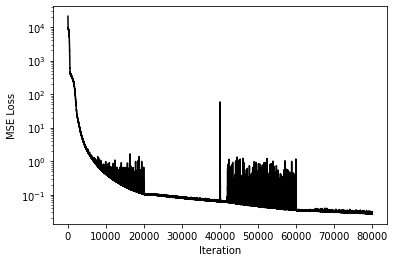

In [29]:
fig, ax = plt.subplots(1)
ax.plot(losses, 'k-')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE Loss')
plt.show()

## Simulation

In [30]:
f_learned = lambda state, control: f_nn.apply(params, state, control)

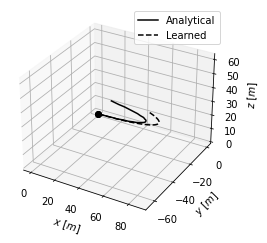

In [31]:
trajs_list = [
  [trajectory_constant(state, control, f_analytical, 50.0, 0.1)],
  [trajectory_constant(state, control, f_learned, 50.0, 0.1)]
]
plot(trajs_list, ['k-', 'k--'], ['Analytical', 'Learned'])

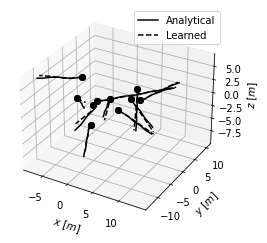

In [32]:
trajs_list = [
    trajectories_constant(states_test, controls_test, f_analytical, 10.0, 0.1),
    trajectories_constant(states_test, controls_test, f_learned, 10.0, 0.1)
]
plot(trajs_list, ['k-', 'k--'], ['Analytical', 'Learned'])